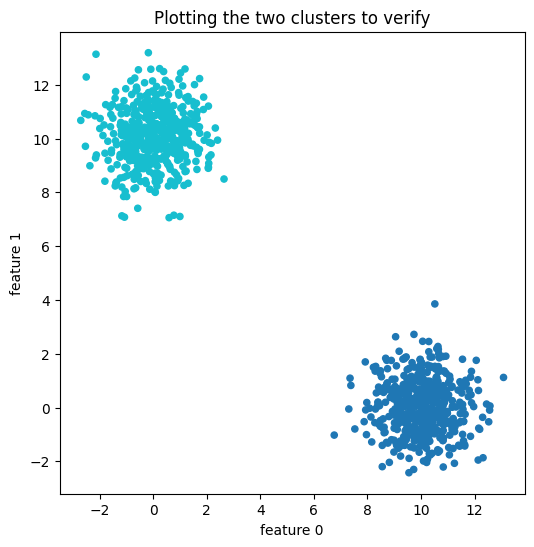

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples = [500, 500],
    centers = [(10, 0), (0, 10)],
    n_features = 2,
    random_state = 42,
    cluster_std = 1.0
)

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=20)
plt.title("Plotting the two clusters to verify")
plt.xlabel("feature 0")
plt.ylabel("feature 1")
plt.show()

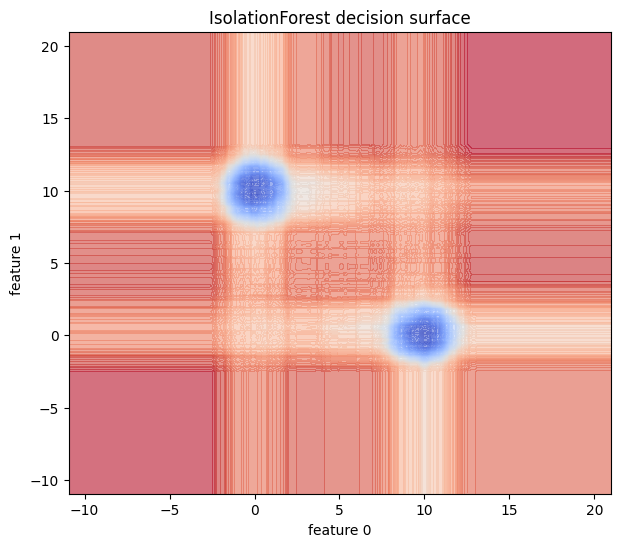

In [ ]:
from pyod.models.iforest import IForest
import numpy as np
import matplotlib.pyplot as plt

contamination = 0.2
iforest_model = IForest(contamination = contamination, random_state = 42)
iforest_model.fit(X)
y_train_pred = iforest_model.predict(X)

X_test = np.random.uniform(low = -10, high = 20, size = (1000,2))
y_test_pred = iforest_model.predict(X_test)
test_scores = iforest_model.decision_function(X_test)

mean_in = test_scores[y_test_pred == 0].mean() if np.any(y_test_pred == 0) else np.nan
mean_out = test_scores[y_test_pred == 1].mean() if np.any(y_test_pred == 1) else np.nan
larger_means_anomalous = np.isnan(mean_out) or (mean_out > mean_in)

raw_scores = test_scores if larger_means_anomalous else -test_scores

pad = 1.0
x_min, x_max = X_test[:,0].min() - pad, X_test[:,0].max() + pad
y_min, y_max = X_test[:,1].min() - pad, X_test[:,1].max() + pad
res = 300
xx = np.linspace(x_min, x_max, res)
yy = np.linspace(y_min, y_max, res)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]

grid_scores = iforest_model.decision_function(grid)
grid_raw = grid_scores if larger_means_anomalous else -grid_scores

global_min = min(raw_scores.min(), grid_raw.min())
global_max = max(raw_scores.max(), grid_raw.max())
eps = 1e-12
grid_norm = (grid_raw - global_min) / (global_max - global_min + eps)
point_norm = (raw_scores - global_min) / (global_max - global_min + eps)

plt.figure(figsize=(7, 6))
plt.contourf(XX, YY, grid_norm.reshape(XX.shape), levels=100, cmap='coolwarm', alpha=0.6)
# sc = plt.scatter(X_test[:, 0], X_test[:, 1], c=point_norm, cmap='viridis', s=25, edgecolors='k', linewidth=0.3)
# plt.colorbar(sc, label='normalized anomaly score (1 = most anomalous)')
# optional: highlight points predicted as outliers by model
out_idx = (y_test_pred == 1)
# if out_idx.any():
#     plt.scatter(X_test[out_idx,0], X_test[out_idx,1], facecolors='none', edgecolors='y', s=60, linewidth=1.2, label='predicted outliers')
plt.title('IsolationForest decision surface')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()